# Explaining Deep Q-Learning with Cartpole
In this example, we build off of our [previous example](./0_explain-policy-gradient-cartpole.ipynb) to learn a different kind of deep learning algorithm: Q-learning. This notebook will introduce a few new concepts:

- [ ] $Q$-functions
- [ ] How to update predictions of value using Bellman's equation
- [ ] Using memory and replay to train an RL agent

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from gym.envs.classic_control import CartPoleEnv
from rlutils import Agent, enact_policy, evaluate_agent, state_cols
from collections import deque
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [2]:
training_cycles = 1024

## Making an Enviroment
(Refer to previous notebook for explanation of environment)

In [3]:
env = CartPoleEnv()

## Learning a Policy: Q-Learning
Let's now move in to trying to use reinforcement learning to learn a better agent, starting with another common technique: Deep Q-learning. [The original paper from DeepMind](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) and the ["Tutorial to RL" from Tensorflow Agents](https://www.tensorflow.org/agents/tutorials/0_intro_rl) explains the theory very clearly. We briefly outline it here.

$Q$-learning involves learning a function that predicts the long-term reward of taking a certain move given a certain state ($Q(s,a)$, hence "Q-learning") instead of the policy function. 
The optimal policy can then be expressed by picking the most valuable action at each state: $\pi(s) = \arg\max_aQ(s,a)$

The value of $Q$ for a certain state ($s$) and action ($a$) cannot be directly measured. Rather, one must gradually learn it by observing the reward of different states and actions over time.
A popular route for learning $Q$ is by updating its value through _value iteration_ (RL Jargon *italicized*) using the "*Bellman equation*," which defines how you can update value of $Q$ given a new observation of the reward ($r$) for a certan action:


$Q_{i+1}(s,a) =  Q_{i}(s_t, a_t) + \alpha (r_t+ \gamma \max_{a'} Q_i(s_{t+1},a') - Q(s_t, a_t))$

where $\alpha$ is a learning rate, $\max_{a'} Q_i(s_{t+1}, a')$ is an estimate of the value of the next state (taken as the best $Q$-value of any action), and $\gamma$ is a discount factor (rewards farther in the future are worth less. 

Each iteration of this equation draws the value of $Q(s_t,a_t)$ to be closer to its true value: the reward immediately received by an action plus the future rewards of the next steps.
It takes many iterations to learn this process because you are simultaneously learning the $Q$ value of every state and action, which are all interdependant. 
Eventually, repeating this process will eventually produce a $Q$ that encompases the future rewards for taking that action through induction because state $t+1$ is affected by $t+2$, which is affected by $t+3$ and so on. Learning $Q$ this way requires a lookup table to hold the values for each state ($s$) and action $s$, which is impractical for complex systems (many different states). Rather, we can learn a model that predicts $Q$, $Q(s, a; \theta)$, where we instead learn parameters ($\theta$) which allow us to predict $Q$ at any state.

### Step 1: Building the agent

Let's start off by building an agent that can take moves using a $Q$ function.

At first, we do not trust our policy enough to pick the most valuable move. So, we use an [$\epsilon$-greedy](https://www.baeldung.com/cs/epsilon-greedy-q-learning#2-epsilon-greedy-action-selection) algorithm that picks a certain fraction of our moves randomly so that we can gather good training data by exploring the space of all possible moves.

In [4]:
class DQNAgent(Agent):
    """An agent trained using DQN"""
    
    def __init__(self, gamma=0.9, epsilon=0.5):
        """
        Args:
            gamma: Discount rate for future rewards
            epsilon: Exploration value
        """
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Make a model that predicts the value of a move and actions
        self.q_function = Sequential([
            Dense(128, use_bias=True, activation='relu', input_shape=(4,)),
            Dense(2, use_bias=False, activation='sigmoid')
        ])
        self.opt = Adam()
    
    def get_action(self, state):       
        # Compute the value of each move
        q_values = self.q_function.predict(state[np.newaxis, :])[0]
        
        if np.random.random() < self.epsilon:
            # Choose action randomly
            return np.random.randint(2)
        else:
            return np.argmax(q_values)
    
    def train(self, states):
        # Not yet!
        pass

Evalaute the agent

In [5]:
agent = DQNAgent()

In [6]:
states = enact_policy(env, agent)

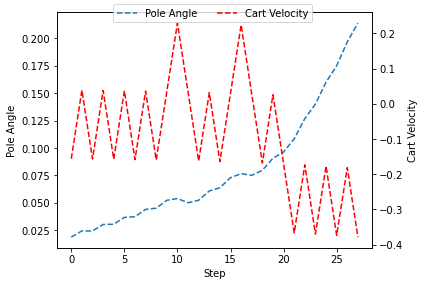

In [7]:
fig, ax = plt.subplots()

ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

So, it doesn't work right away and if we look at the $Q(s,a)$ for each step we can see why

Text(0, 0.5, 'Step')

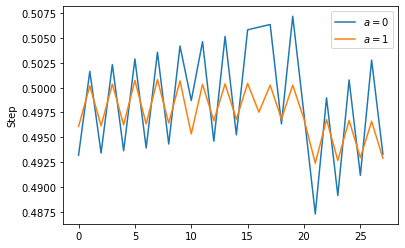

In [8]:
fig, ax = plt.subplots()

q_values = agent.q_function.predict(states[state_cols])

ax.plot(q_values[:, 0], label='$a=0$')
ax.plot(q_values[:, 1], label='$a=1$')
ax.legend()

ax.set_ylabel('$Q(s, a)$')
ax.set_ylabel('Step')

Note how the value of the moves stay roughly constant with time, which isn't what I'd expect. The future rewards should be diminishing towards the end of the episode, because the pole is about to tip over and there are fewer future rewards are available as a result.

## Step 2: Training the Agent

We update our model by minimizing a loss function that is derived from the Bellman equation above.

$L(\theta_i) = \mathbb{E} [(y_i - Q(s,a;\theta_i))^2]$

$y_i = r_t+ \gamma\max_{a'} (Q(s',a'; \theta_{i-1}))$

This is based on the idea that value of taking in action in a state _should_ be equal to the value of the reward received ($r_t$) plus the value of the next state ($\max_{a'}Q(s',a')$) decayed by a certain factor ($\gamma$). If this is not true, there is a problem in our model we need to correct. Hence, we define the expression as a loss function.

*Aside*: Note that we express the loss as a function of the current parameters ($\theta_i$), but use the parameters from the previous step ($\theta_{i-1}$) when computing the target $Q$ value ($y_i$) so that we are only changing how we predict the $Q$-function for one state and not both simultaneously.

Here, we implement this algorithm and also introduce a concept of "memory" for RL agents that holds on to previous experiences so that we continually train using them.

In [9]:
class DQNAgent(Agent):
    """An agent trained using DQN"""
    
    def __init__(self, gamma=0.9, epsilon=0.75, epsilon_decay=0.01, epsilon_min=0.1):
        """
        Args:
            gamma: Discount rate for future rewards
            epsilon: Exploration value
            epsilon_decay: How much we decay the rewards after each update
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Make a model that predicts the value of a move and actions
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer='adam')
        
        # Memory for all observed moves
        self.memory = pd.DataFrame()
        self.max_memory = 2048
        
    def make_q_function(self):
        """Generate a Q-function that computes the value of both actions given state"""
        return Sequential([
            Dense(128, activation='relu', input_shape=(4,)),
            Dense(64, activation='relu', input_shape=(4,)),
            Dense(2, activation='linear')
        ])
    
    def get_action(self, state):       
        if np.random.random() < self.epsilon:
            # Choose action randomly
            return np.random.randint(2)
        else:
            # Compute the value of each move
            q_values = self.q_function.predict(state[np.newaxis, :])[0]
            
            # Pick the best value
            return np.argmax(q_values)
    
    def train(self, states):
        # Compute the next state for each state
        #  Numpy roll rotates the array from [1, ... N] to [2, ... N, 1]
        next_state_cols = []  # Stores the columns in the DataFrame that involve refitting the 
        for c in state_cols:
            next_state_cols.append(f'next_{c}')
            states[f'next_{c}'] = np.roll(states[c], -1)
        
        # Add new states to the memory
        self.memory = pd.concat([self.memory, states])
        
        # If needed, sample fewer points from the memory to keep it from becoming too big
        if len(self.memory) > self.max_memory:
            self.memory = self.memory.sample(self.max_memory)
        
        # Get compute the Q value for the next state
        #  The value is zero for the last point because there is no next state
        q_value_next = np.max(self.q_function.predict(self.memory[next_state_cols].values), axis=1)
        q_value_next = np.where(self.memory['done'], 0, q_value_next)
        
        # Compute the target Q-values
        q_target = self.memory['reward'].values + self.gamma * q_value_next
        
        # Save the old weights
        self.q_function.fit(self.memory[state_cols].values, q_target, shuffle=True, batch_size=32, verbose=False)
        
        # Last step, make the algorithm more greedy
        self.epsilon *= (1 - self.epsilon_decay)
        self.epsilon = max(self.epsilon, self.epsilon_min)
        return 
agent = DQNAgent()

In [10]:
dqn_results = evaluate_agent(env, agent, 1024)

Over time, our episodes become longer because the agent is getting better at balancing the pole and we are decaying the $\epsilon$ value so the agent takes random moves less often.

Text(0, 0.5, 'Episode Length')

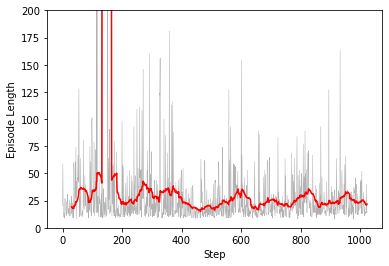

In [15]:
fig, ax = plt.subplots()

ax.plot(dqn_results['length'], 'k', lw=0.5, alpha=0.3)
ax.plot(dqn_results['length'].rolling(32).mean(), 'r')

ax.set_ylim(0, 200)

ax.set_xlabel('Step')
ax.set_ylabel('Episode Length')

Showing one as a demonstration

In [12]:
states = enact_policy(env, agent)

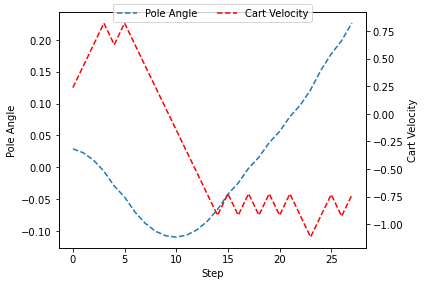

In [13]:
fig, ax = plt.subplots()

ax.plot(states['step'], states['pole_angle'], '--', label='Pole Angle')

ax2 = ax.twinx()
ax2.plot(states['step'], states['cart_velocity'], '--', color='red', label='Cart Velocity')

ax.set_xlabel('Step')
ax.set_ylabel('Pole Angle')
ax2.set_ylabel('Cart Velocity')

fig.legend(loc='upper center', ncol=2)
fig.tight_layout()

We can see why in the improved $Q$-function

Text(0, 0.5, 'Step')

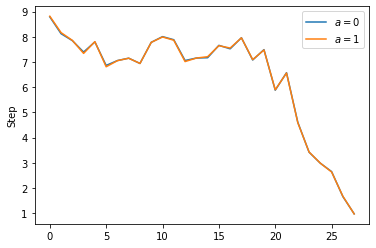

In [14]:
fig, ax = plt.subplots()

q_values = agent.q_function.predict(states[state_cols])

ax.plot(q_values[:, 0], label='$a=0$')
ax.plot(q_values[:, 1], label='$a=1$')
ax.legend()

ax.set_ylabel('$Q(s, a)$')
ax.set_ylabel('Step')

The $Q$-value now decays towards the end of the episode, where the pole is falling over and the amount of rewards we can hope to expect diminish.

Now that you have seen all this, you should know
- [ ] $Q$-functions *predict the future reward of taking an action in a certain state.*
- [ ] How to update predictions of value using Bellman's equation, *which relates the value of a future state to the reward for taking an action plus the value of the next state.*
- [ ] Using memory and replay to train an RL agent *by holding on to all past moves and using them repeatedly to train the policy.*